# 步骤 1：初步探索 TF-IDF 阈值

In [43]:
import os
import glob
import pandas as pd
import numpy as np
from collections import defaultdict
from gensim import corpora, models
from gensim.models import CoherenceModel
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [14]:
# Set working directory to project root
project_root = '/Users/jessie/Documents/Projects/Cusanus_Topic_Modeling'
os.chdir(project_root)
print("Current working directory: ", os.getcwd())

Current working directory:  /Users/jessie/Documents/Projects/Cusanus_Topic_Modeling


In [44]:
# 定义全局参数
fixed_num_topics = 15
fixed_alpha = 'symmetric'
fixed_eta = 'symmetric'
passes = 10
iterations = 100
kfold_splits = 5
random_state = 42

# 权重网格搜索范围
alpha_range = np.arange(0.3, 0.7, 0.1)  # NPMI权重
lambda_range = np.arange(0.1, 0.4, 0.1)  # Overlap惩罚权重

# 为不同方法定义不同的 TF-IDF 阈值范围
tfidf_thresholds = {
    'cusanus': np.arange(0.20, 0.36, 0.01),
    'cltk': np.arange(0.10, 0.21, 0.01),
    'stanza': np.arange(0.10, 0.21, 0.01)
}

# 数据集路径
datasets = {
    'cusanus': 'data/preprocessed/cusanus',
    'cltk': 'data/preprocessed/cltk',
    'stanza': 'data/preprocessed/stanza'
}

# 创建必要的目录
os.makedirs('experiments/lda/logs', exist_ok=True)
os.makedirs('experiments/lda/results', exist_ok=True)
os.makedirs('summaries', exist_ok=True)


In [45]:
def load_paragraphs(data_dir):
    """
    加载数据目录下的所有文档，并将其拆分为段落。
    返回段落列表，以及对应的段落信息（文档名、段落编号）。
    """
    paragraphs = []
    paragraph_info = []
    files = glob.glob(os.path.join(data_dir, '*.txt'))
    for file_path in files:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            # 按段落拆分
            raw_paragraphs = text.split('Paragraph ')
            for raw_para in raw_paragraphs:
                if not raw_para.strip():
                    continue
                # 提取段落编号和内容
                try:
                    # 分离段落编号和内容
                    number_and_text = raw_para.strip().split(':', 1)
                    if len(number_and_text) == 2:
                        para_number = number_and_text[0].strip()
                        para_text = number_and_text[1].strip()
                    else:
                        # 如果没有冒号，整个都是段落内容
                        para_number = None
                        para_text = number_and_text[0].strip()
                    # 移除段落编号中的非数字字符
                    para_number = ''.join(filter(str.isdigit, str(para_number))) if para_number else None
                except Exception as e:
                    print(f"解析段落时出错：{e}")
                    continue
                if para_text:
                    paragraphs.append(para_text)
                    paragraph_info.append({
                        'file': os.path.basename(file_path),
                        'paragraph_number': para_number
                    })
    return paragraphs, paragraph_info

# 加载所有数据集的段落
data_paragraphs = {}
data_paragraph_info = {}

for method, path in datasets.items():
    print(f"加载 {method} 数据集的段落...")
    paragraphs, paragraph_info = load_paragraphs(path)
    data_paragraphs[method] = paragraphs
    data_paragraph_info[method] = paragraph_info
    print(f"共加载 {len(paragraphs)} 个段落。\n")


加载 cusanus 数据集的段落...
共加载 4645 个段落。

加载 cltk 数据集的段落...
共加载 4515 个段落。

加载 stanza 数据集的段落...
共加载 4515 个段落。



In [46]:
def compute_tfidf_and_filter(documents, tfidf_threshold):
    """计算 TF-IDF 值并根据阈值过滤词汇"""
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.max(axis=0).toarray()[0]
    
    vocab_tfidf = dict(zip(feature_names, tfidf_scores))
    filtered_vocab = {word: tfidf for word, tfidf in vocab_tfidf.items() if tfidf >= tfidf_threshold}
    filtered_words = set(filtered_vocab.keys())
    
    filtered_documents = []
    for doc in documents:
        words = doc.split()
        filtered_doc = [word for word in words if word in filtered_words]
        filtered_documents.append(' '.join(filtered_doc))
    
    return filtered_documents, filtered_vocab

def filter_doc_by_dictionary(doc, dictionary):
    """根据训练集的词典，过滤验证集中的未见词"""
    words = doc.split()
    filtered_words = [word for word in words if word in dictionary.token2id]
    return ' '.join(filtered_words)

In [47]:
def compute_topic_overlap(model, num_topics, top_n=10):
    """计算主题之间的平均重叠度"""
    topic_words = []
    for topic_id in range(num_topics):
        top_words = set(word for word, _ in model.show_topic(topic_id, topn=top_n))
        topic_words.append(top_words)
    
    overlap_scores = []
    for i in range(num_topics):
        for j in range(i + 1, num_topics):
            intersection = len(topic_words[i] & topic_words[j])
            union = len(topic_words[i] | topic_words[j])
            jaccard = intersection / union if union > 0 else 0
            overlap_scores.append(jaccard)
    
    return np.mean(overlap_scores) if overlap_scores else 0

def normalize_metrics(npmi, diversity, overlap):
    """对指标进行标准化处理"""
    normalized_npmi = (npmi + 1) / 2
    normalized_diversity = diversity
    normalized_overlap = 1 - overlap
    return normalized_npmi, normalized_diversity, normalized_overlap

def compute_optimal_score(npmi, diversity, overlap, alpha, lambda_val):
    """计算标准化后的综合得分"""
    norm_npmi, norm_diversity, norm_overlap = normalize_metrics(npmi, diversity, overlap)
    return alpha * norm_npmi + (1 - alpha) * norm_diversity - lambda_val * (1 - norm_overlap)

In [48]:
# 步骤 5：加载数据
print("加载数据集...")
data_paragraphs = {}
data_paragraph_info = {}



for method, path in datasets.items():
    print(f"加载 {method} 数据集的段落...")
    paragraphs, paragraph_info = load_paragraphs(path)
    data_paragraphs[method] = paragraphs
    data_paragraph_info[method] = paragraph_info
    print(f"共加载 {len(paragraphs)} 个段落。\n")

加载数据集...
加载 cusanus 数据集的段落...
共加载 4645 个段落。

加载 cltk 数据集的段落...
共加载 4515 个段落。

加载 stanza 数据集的段落...
共加载 4515 个段落。



In [49]:
# 步骤 6：主实验循环
results = []

for method, paragraphs in tqdm(data_paragraphs.items(), desc="处理数据集"):
    print(f"\n开始处理 {method} 数据集...")
    method_thresholds = tfidf_thresholds[method]
    
    paragraphs = np.array(paragraphs)
    paragraph_info = np.array(data_paragraph_info[method])
    
    kf = KFold(n_splits=kfold_splits, shuffle=True, random_state=random_state)
    
    for tfidf_threshold in tqdm(method_thresholds, desc=f"{method} TF-IDF阈值"):
        print(f"\nTF-IDF 阈值：{tfidf_threshold:.3f}")
        
        fold = 1
        for train_index, val_index in kf.split(paragraphs):
            try:
                print(f" - 第 {fold} 折...")
                # 划分训练集和验证集
                train_paras = paragraphs[train_index]
                val_paras = paragraphs[val_index]
                
                # 数据预处理
                filtered_train_paras, filtered_vocab = compute_tfidf_and_filter(
                    train_paras.tolist(), 
                    tfidf_threshold
                )
                
                dictionary = corpora.Dictionary(para.split() for para in filtered_train_paras)
                corpus = [dictionary.doc2bow(para.split()) for para in filtered_train_paras]
                filtered_val_paras = [filter_doc_by_dictionary(para, dictionary) for para in val_paras]
                
                # 训练模型
                lda_model = models.LdaModel(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=fixed_num_topics,
                    alpha=fixed_alpha,
                    eta=fixed_eta,
                    passes=passes,
                    iterations=iterations,
                    random_state=random_state
                )
                
                # 评估基础指标
                coherence_model = CoherenceModel(
                    model=lda_model,
                    texts=[para.split() for para in filtered_val_paras],
                    dictionary=dictionary,
                    coherence='c_npmi'
                )
                npmi = coherence_model.get_coherence()
                
                top_words_per_topic = []
                for topic_id in range(fixed_num_topics):
                    top_words = [word for word, prob in lda_model.show_topic(topic_id, topn=10)]
                    top_words_per_topic.extend(top_words)
                unique_top_words = set(top_words_per_topic)
                diversity = len(unique_top_words) / (fixed_num_topics * 10)
                
                overlap = compute_topic_overlap(lda_model, fixed_num_topics)
                
                # 评估不同权重组合
                for alpha in alpha_range:
                    for lambda_val in lambda_range:
                        optimal_score = compute_optimal_score(
                            npmi, diversity, overlap, alpha, lambda_val
                        )
                        
                        result = {
                            'method': method,
                            'tfidf_threshold': tfidf_threshold,
                            'fold': fold,
                            'num_topics': fixed_num_topics,
                            'alpha_weight': alpha,
                            'lambda_weight': lambda_val,
                            'npmi_raw': npmi,
                            'diversity_raw': diversity,
                            'overlap_raw': overlap,
                            'npmi_norm': (npmi + 1) / 2,
                            'diversity_norm': diversity,
                            'overlap_norm': 1 - overlap,
                            'optimal_score': optimal_score
                        }
                        results.append(result)
                
            except Exception as e:
                print(f"处理第 {fold} 折时出错: {str(e)}")
                continue
            
            fold += 1

处理数据集:   0%|          | 0/3 [00:00<?, ?it/s]


开始处理 cusanus 数据集...



TF-IDF 阈值：0.200
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.210
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.220
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.230
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.240
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...


/Users/jessie/miniforge3/envs/cusanus_env/lib/python3.10/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)


 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.250
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.260
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.270
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.280
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.290
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.300
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.310
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.320
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.330
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.340
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.350
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...


处理数据集:  33%|███▎      | 1/3 [15:17<30:35, 917.61s/it]


开始处理 cltk 数据集...



TF-IDF 阈值：0.100
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.110
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.120
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.130
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.140
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.150
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.160
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.170
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.180
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.190
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.200
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...


处理数据集:  67%|██████▋   | 2/3 [26:49<13:04, 784.75s/it]


开始处理 stanza 数据集...



TF-IDF 阈值：0.100
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.110
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.120
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.130
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.140
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.150
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.160
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.170
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.180
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.190
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...



TF-IDF 阈值：0.200
 - 第 1 折...
 - 第 2 折...
 - 第 3 折...
 - 第 4 折...
 - 第 5 折...


处理数据集: 100%|██████████| 3/3 [39:09<00:00, 783.20s/it]


In [50]:
# 步骤 7：结果分析和保存
experiment_log = pd.DataFrame(results)
experiment_log.to_excel('experiments/lda/logs/experiment_log_weights.xlsx', index=False)

In [51]:
# 分析最佳权重组合
best_configs = (experiment_log.groupby(['method', 'alpha_weight', 'lambda_weight'])
               ['optimal_score'].mean()
               .reset_index()
               .sort_values('optimal_score', ascending=False))

print("\n各方法的最佳权重组合：")
for method in experiment_log['method'].unique():
    method_best = best_configs[best_configs['method'] == method].iloc[0]
    print(f"\n{method}:")
    print(f"最佳 ALPHA (NPMI权重): {method_best['alpha_weight']:.2f}")
    print(f"最佳 LAMBDA (Overlap惩罚): {method_best['lambda_weight']:.2f}")
    print(f"平均得分: {method_best['optimal_score']:.4f}")

# 保存详细的权重分析结果
weight_analysis = pd.pivot_table(
    experiment_log,
    values='optimal_score',
    index=['method', 'tfidf_threshold'],
    columns=['alpha_weight', 'lambda_weight'],
    aggfunc='mean'
).round(4)

weight_analysis.to_excel('experiments/lda/logs/weight_analysis.xlsx')


各方法的最佳权重组合：

cusanus:
最佳 ALPHA (NPMI权重): 0.50
最佳 LAMBDA (Overlap惩罚): 0.30
平均得分: inf

cltk:
最佳 ALPHA (NPMI权重): 0.30
最佳 LAMBDA (Overlap惩罚): 0.10
平均得分: inf

stanza:
最佳 ALPHA (NPMI权重): 0.30
最佳 LAMBDA (Overlap惩罚): 0.10
平均得分: inf


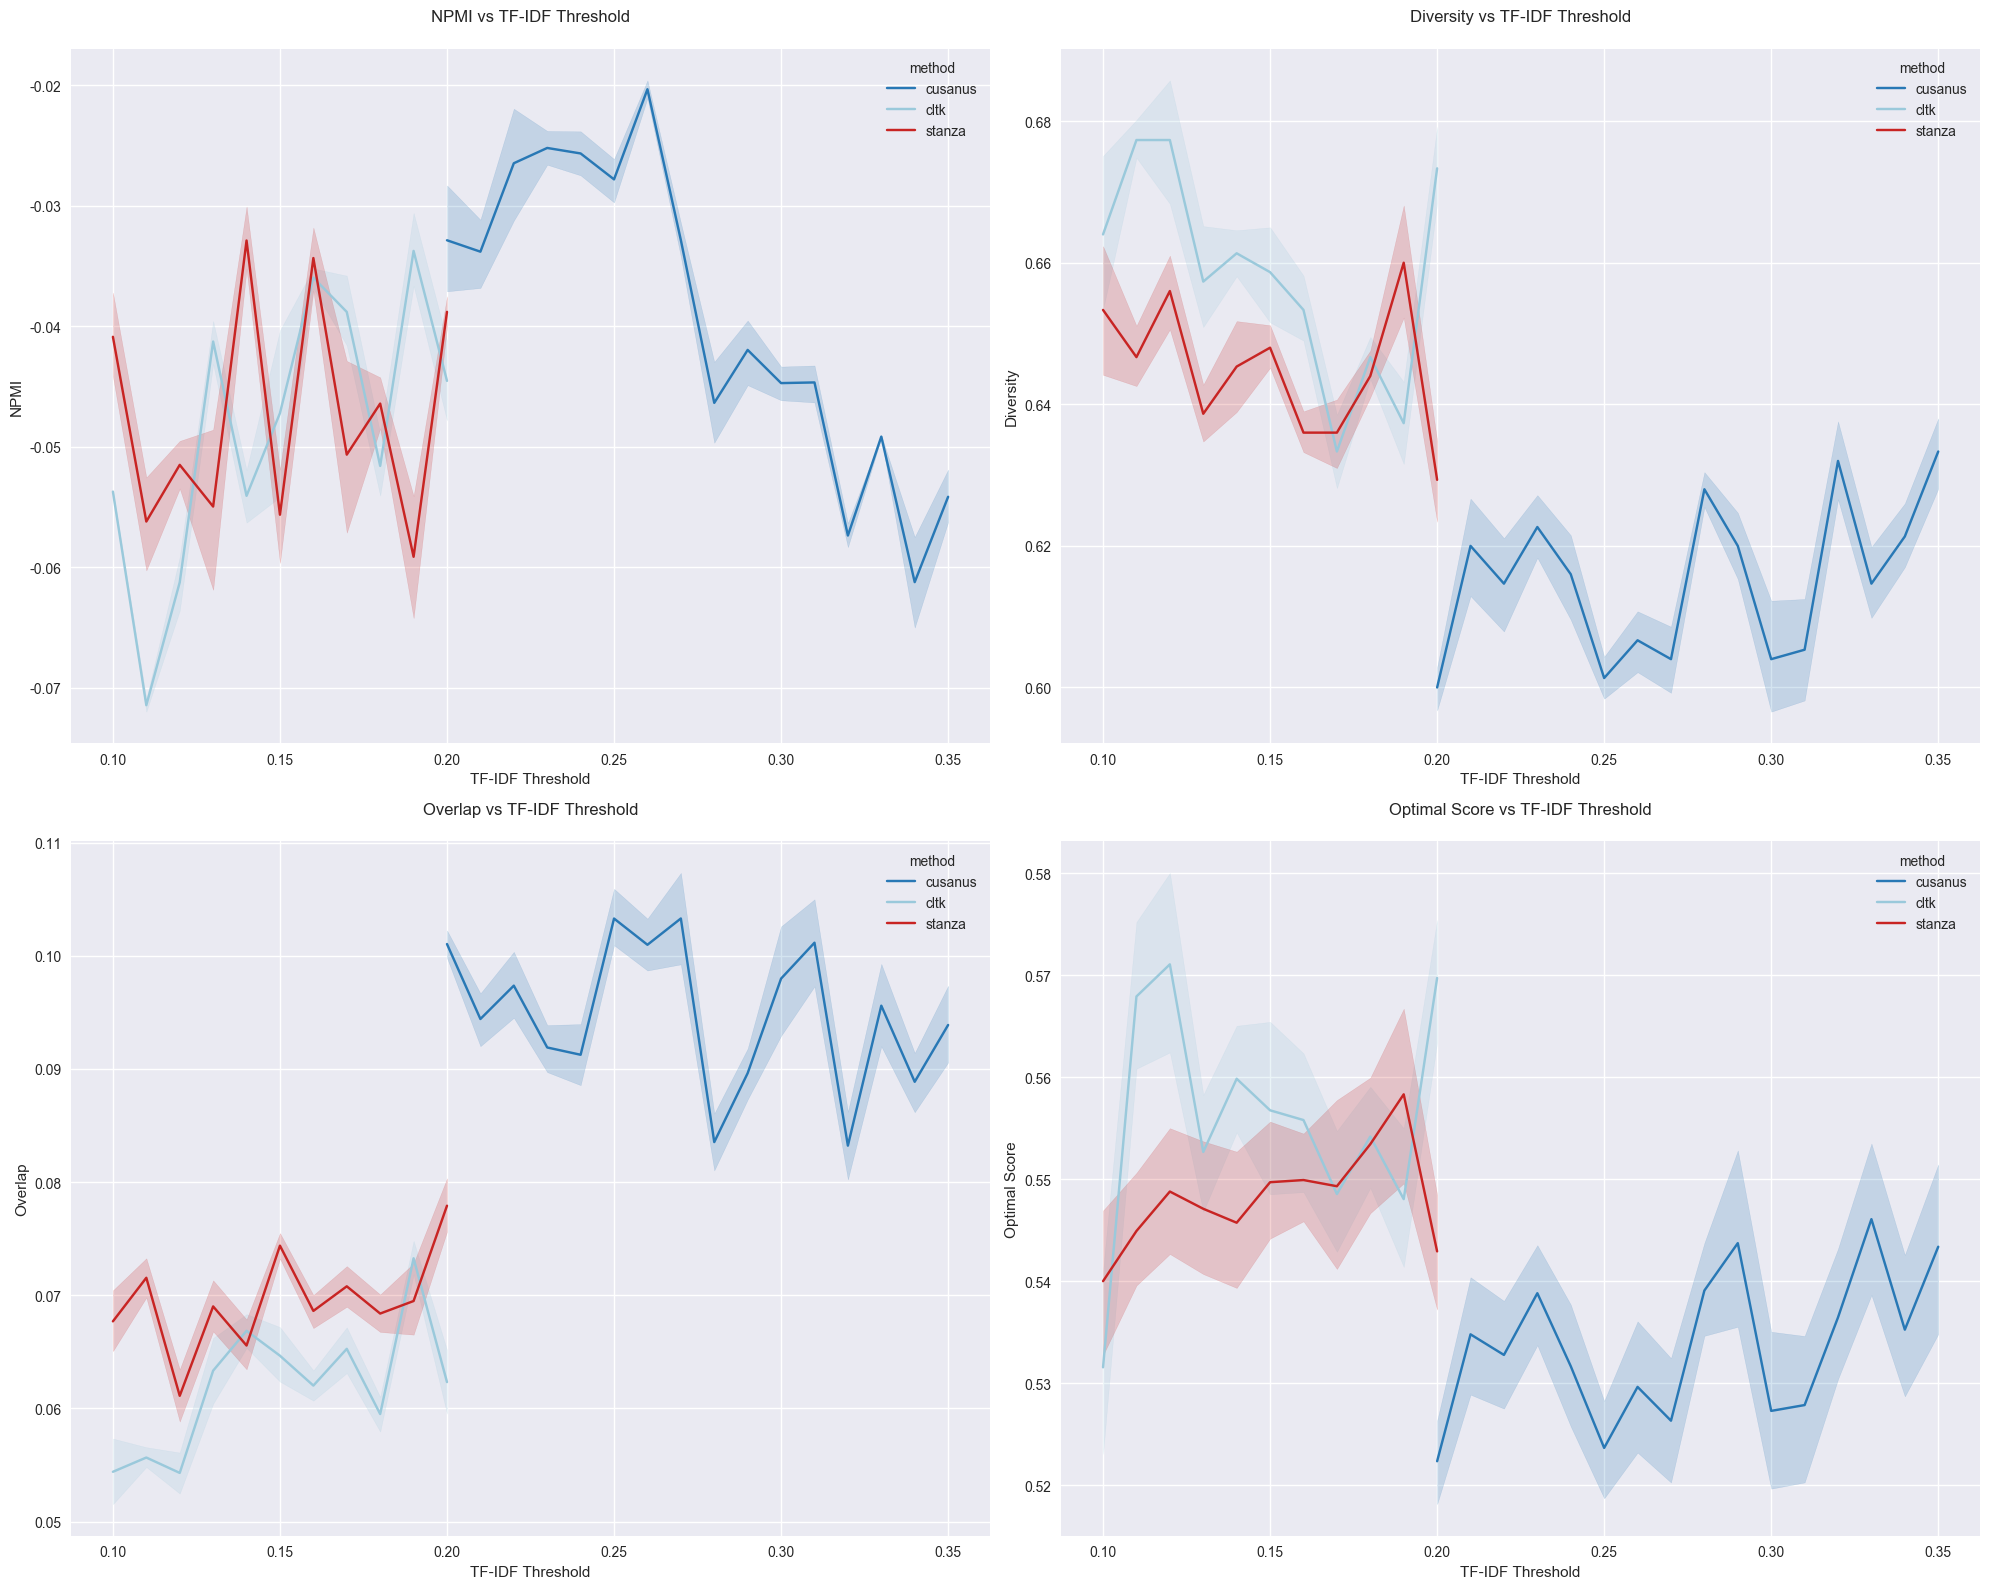

In [52]:
# 步骤 8：可视化结果
plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 创建多个子图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 设置颜色方案
colors = ['#2878B5', '#9AC9DB', '#C82423']
method_colors = dict(zip(experiment_log['method'].unique(), colors))

# 1. NPMI vs TF-IDF Threshold
sns.lineplot(
    data=experiment_log,
    x='tfidf_threshold',
    y='npmi_raw',
    hue='method',
    ax=ax1,
    palette=method_colors
)
ax1.set_title('NPMI vs TF-IDF Threshold', pad=20)
ax1.set_xlabel('TF-IDF Threshold')
ax1.set_ylabel('NPMI')

# 2. Diversity vs TF-IDF Threshold
sns.lineplot(
    data=experiment_log,
    x='tfidf_threshold',
    y='diversity_raw',
    hue='method',
    ax=ax2,
    palette=method_colors
)
ax2.set_title('Diversity vs TF-IDF Threshold', pad=20)
ax2.set_xlabel('TF-IDF Threshold')
ax2.set_ylabel('Diversity')

# 3. Overlap vs TF-IDF Threshold
sns.lineplot(
    data=experiment_log,
    x='tfidf_threshold',
    y='overlap_raw',
    hue='method',
    ax=ax3,
    palette=method_colors
)
ax3.set_title('Overlap vs TF-IDF Threshold', pad=20)
ax3.set_xlabel('TF-IDF Threshold')
ax3.set_ylabel('Overlap')

# 4. Optimal Score vs TF-IDF Threshold
sns.lineplot(
    data=experiment_log,
    x='tfidf_threshold',
    y='optimal_score',
    hue='method',
    ax=ax4,
    palette=method_colors
)
ax4.set_title('Optimal Score vs TF-IDF Threshold', pad=20)
ax4.set_xlabel('TF-IDF Threshold')
ax4.set_ylabel('Optimal Score')

plt.tight_layout()
plt.savefig('summaries/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 保存最佳配置
best_configs.to_json('experiments/lda/results/best_configurations.json', orient='records', indent=2)

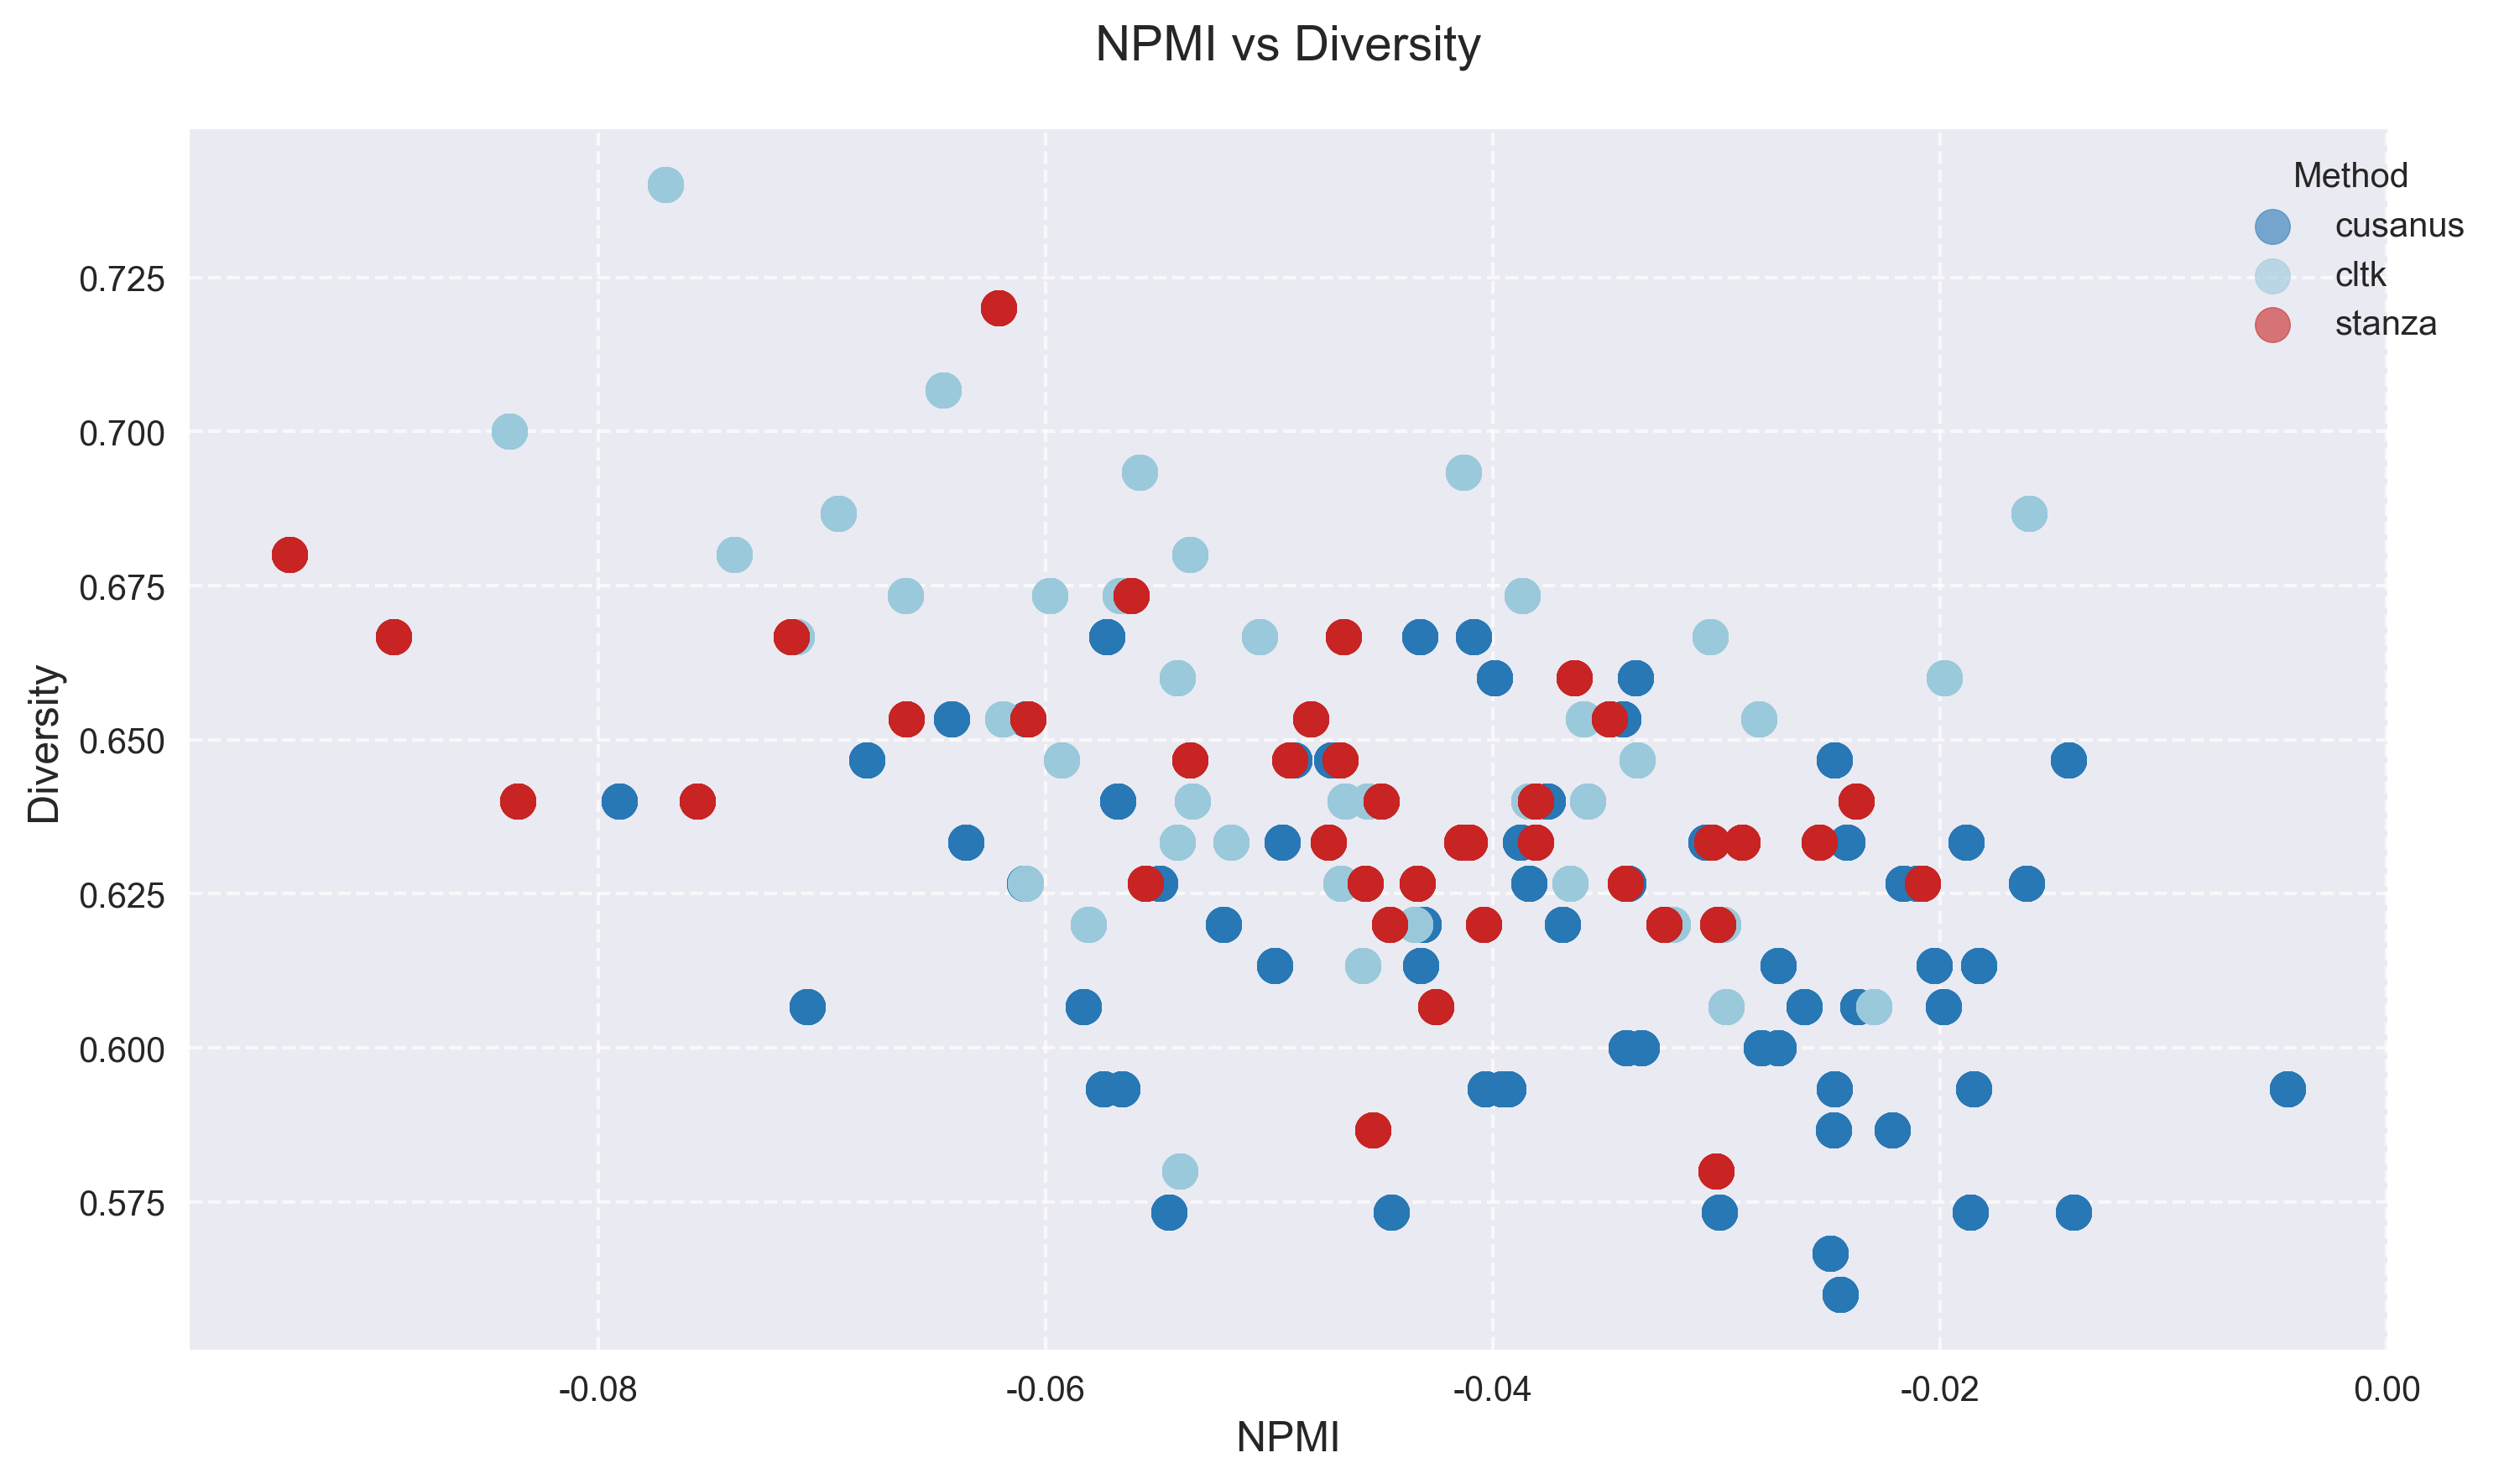


各方法的 NPMI 和 Diversity 相关性：
cusanus: nan
cltk: nan
stanza: nan


/Users/jessie/miniforge3/envs/cusanus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [54]:
# 创建 NPMI vs Diversity 散点图
plt.figure(figsize=(10, 6), dpi=300)

# 设置颜色方案
colors = ['#2878B5', '#9AC9DB', '#C82423']
method_colors = dict(zip(experiment_log['method'].unique(), colors))

# 为每个方法绘制散点图
for method in experiment_log['method'].unique():
    method_data = experiment_log[experiment_log['method'] == method]
    plt.scatter(
        method_data['npmi_raw'],        # 修改：使用 'npmi_raw' 而不是 'npmi'
        method_data['diversity_raw'],    # 修改：使用 'diversity_raw' 而不是 'diversity'
        label=method,
        alpha=0.6,
        s=100,
        c=[method_colors[method]]
    )

plt.title('NPMI vs Diversity', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('NPMI', fontsize=12)
plt.ylabel('Diversity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Method', bbox_to_anchor=(1.05, 1))

# 调整布局
plt.tight_layout()

# 保存图片
plt.savefig(
    'summaries/npmi_vs_diversity_scatter.png',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.2
)

plt.show()

# 打印相关性分析
print("\n各方法的 NPMI 和 Diversity 相关性：")
for method in experiment_log['method'].unique():
    method_data = experiment_log[experiment_log['method'] == method]
    correlation = method_data['npmi_raw'].corr(method_data['diversity_raw'])
    print(f"{method}: {correlation:.4f}")

In [33]:
# 步骤 2：LDA 参数调优的配置

# 根据第一步实验结果设置最佳阈值
best_tfidf_thresholds = {
    'cusanus': 0.15,  # 根据实际实验结果调整
    'cltk': 0.15,     # 根据实际实验结果调整
    'stanza': 0.15    # 根据实际实验结果调整
}

# LDA参数搜索空间
num_topics_list = [10, 15, 20, 25, 30]
alpha_list = ['symmetric', 0.1, 0.3, 0.5, 0.7]
eta_list = ['symmetric', 0.1, 0.3, 0.5, 0.7]

# 基础路径配置
EXPERIMENT_DIR = 'experiments'
MODEL_DIR = 'models'
RESULTS_DIR = 'results'
LOGS_DIR = 'logs'

# 创建必要的目录
for method in data_paragraphs.keys():
    for dir_name in [MODEL_DIR, RESULTS_DIR, LOGS_DIR]:
        os.makedirs(os.path.join(EXPERIMENT_DIR, method), exist_ok=True)

In [ ]:
# 初始化结果列表
results_step2 = []
temp_results_file = os.path.join(EXPERIMENT_DIR, 'temp_results_step2.xlsx')

# 如果存在临时结果文件，加载它
if os.path.exists(temp_results_file):
    temp_df = pd.read_excel(temp_results_file)
    results_step2 = temp_df.to_dict('records')
    print(f"加载了 {len(results_step2)} 条临时结果记录")

for method, paragraphs in tqdm(data_paragraphs.items(), desc="处理数据集"):
    print(f"\n开始处理 {method} 数据集（调优 LDA 参数）...")
    
    try:
        tfidf_threshold = best_tfidf_thresholds[method]
        print(f"使用最佳 TF-IDF 阈值：{tfidf_threshold}")
        
        # 转换为 numpy 数组，方便索引
        paragraphs = np.array(paragraphs)
        paragraph_info = np.array(data_paragraph_info[method])
        
        # 创建 KFold 对象
        kf = KFold(n_splits=kfold_splits, shuffle=True, random_state=random_state)
        
        for fold, (train_index, val_index) in enumerate(kf.split(paragraphs), 1):
            print(f" - 第 {fold} 折...")
            try:
                # 划分训练集和验证集
                train_paras = paragraphs[train_index]
                val_paras = paragraphs[val_index]
                
                # 计算训练集的 TF-IDF，过滤词汇
                filtered_train_paras, filtered_vocab = compute_tfidf_and_filter(train_paras.tolist(), tfidf_threshold)
                
                # 创建词典和训练语料库
                dictionary = corpora.Dictionary(para.split() for para in filtered_train_paras)
                corpus = [dictionary.doc2bow(para.split()) for para in filtered_train_paras]
                
                # 准备验证集
                filtered_val_paras = [filter_doc_by_dictionary(para, dictionary) for para in val_paras]
                val_corpus = [dictionary.doc2bow(para.split()) for para in filtered_val_paras]
                
                # 对每个参数组合训练和评估 LDA 模型
                for num_topics in tqdm(num_topics_list, desc="主题数量"):
                    for alpha in alpha_list:
                        for eta in eta_list:
                            try:
                                # 设置模型参数
                                lda_params = {
                                    'num_topics': num_topics,
                                    'alpha': alpha,
                                    'eta': eta,
                                    'passes': passes,
                                    'iterations': iterations,
                                    'random_state': random_state
                                }
                                
                                # 创建模型保存路径
                                model_dir = os.path.join(EXPERIMENT_DIR, method, 
                                                       f'tfidf_{tfidf_threshold}')
                                
                                # 训练 LDA 模型
                                print(f"   训练 LDA 模型：num_topics={num_topics}, alpha={alpha}, eta={eta}")
                                lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, **lda_params)
                                
                                # 评估模型
                                print("   评估模型...")
                                coherence_model = CoherenceModel(
                                    model=lda_model, 
                                    texts=[para.split() for para in filtered_val_paras],
                                    dictionary=dictionary, 
                                    coherence='c_npmi'
                                )
                                npmi = coherence_model.get_coherence()
                                
                                # 计算主题多样性
                                top_words_per_topic = []
                                for topic_id in range(num_topics):
                                    top_words = [word for word, prob in lda_model.show_topic(topic_id, topn=10)]
                                    top_words_per_topic.extend(top_words)
                                unique_top_words = set(top_words_per_topic)
                                diversity = len(unique_top_words) / (num_topics * 10)
                                
                                # 保存结果
                                result_dir = os.path.join(model_dir, 
                                                        f'num_topics_{num_topics}_alpha_{alpha}_eta_{eta}')
                                os.makedirs(result_dir, exist_ok=True)
                                
                                # 保存模型
                                model_path = os.path.join(result_dir, MODEL_DIR, 'lda_model.pkl')
                                os.makedirs(os.path.dirname(model_path), exist_ok=True)
                                lda_model.save(model_path)
                                
                                # 保存评估指标
                                metrics_path = os.path.join(result_dir, RESULTS_DIR, 'metrics.json')
                                os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
                                with open(metrics_path, 'w') as f:
                                    json.dump({'npmi': npmi, 'diversity': diversity}, f)
                                
                                # 保存主题关键词
                                topic_keywords = []
                                for topic_id in range(num_topics):
                                    words = lda_model.show_topic(topic_id, topn=10)
                                    topic_keywords.append({
                                        'topic_id': topic_id,
                                        'keywords': [word for word, prob in words]
                                    })
                                topic_keywords_df = pd.DataFrame(topic_keywords)
                                keywords_path = os.path.join(result_dir, RESULTS_DIR, 'keywords.xlsx')
                                topic_keywords_df.to_excel(keywords_path, index=False)
                                
                                # 记录结果
                                result = {
                                    'method': method,
                                    'tfidf_threshold': tfidf_threshold,
                                    'fold': fold,
                                    'num_topics': num_topics,
                                    'alpha': alpha,
                                    'eta': eta,
                                    'npmi': npmi,
                                    'diversity': diversity
                                }
                                results_step2.append(result)
                                
                                # 每10个结果保存一次临时文件
                                if len(results_step2) % 10 == 0:
                                    temp_df = pd.DataFrame(results_step2)
                                    temp_df.to_excel(temp_results_file, index=False)
                                    
                            except Exception as e:
                                print(f"处理参数组合时出错 (topics={num_topics}, alpha={alpha}, eta={eta}): {e}")
                                continue
                                
            except Exception as e:
                print(f"处理折叠 {fold} 时出错: {e}")
                continue
                
    except Exception as e:
        print(f"处理方法 {method} 时出错: {e}")
        continue

# 保存最终结果
experiment_log_step2 = pd.DataFrame(results_step2)
experiment_log_step2.to_excel(os.path.join(EXPERIMENT_DIR, 'experiment_log_step2.xlsx'), index=False)
print("\n实验日志已保存到", os.path.join(EXPERIMENT_DIR, 'experiment_log_step2.xlsx'))

In [ ]:
# 分析实验结果
def analyze_results(experiment_log):
    # 计算每个方法和参数组合的平均性能
    avg_performance = experiment_log.groupby(
        ['method', 'num_topics', 'alpha', 'eta']
    )[['npmi', 'diversity']].mean().reset_index()
    
    # 找出每个方法的最佳参数组合
    best_params = {}
    for method in avg_performance['method'].unique():
        method_results = avg_performance[avg_performance['method'] == method]
        best_result = method_results.loc[method_results['npmi'].idxmax()]
        best_params[method] = {
            'num_topics': best_result['num_topics'],
            'alpha': best_result['alpha'],
            'eta': best_result['eta'],
            'npmi': best_result['npmi'],
            'diversity': best_result['diversity']
        }
    
    return avg_performance, best_params

# 分析结果
avg_performance, best_params = analyze_results(experiment_log_step2)

# 打印最佳参数
print("\n各方法的最佳参数组合：")
for method, params in best_params.items():
    print(f"\n{method}:")
    for param, value in params.items():
        print(f"  {param}: {value}")

# 保存分析结果
avg_performance.to_excel(os.path.join(RESULTS_DIR, 'average_performance.xlsx'), index=False)
with open(os.path.join(RESULTS_DIR, 'best_parameters.json'), 'w') as f:
    json.dump(best_params, f, indent=4)